In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ap = pd.read_csv('./data/AirPassengers.csv')

In [3]:
ap.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
# Month 컬럼 삭제
ap.drop(columns=['Month'], inplace=True, errors='ignore')

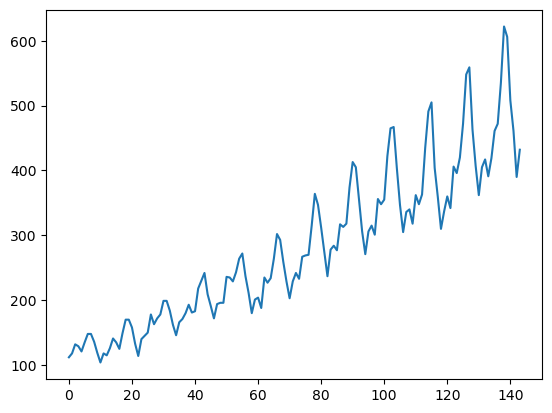

In [5]:
plt.plot(ap)
plt.show()

In [6]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)

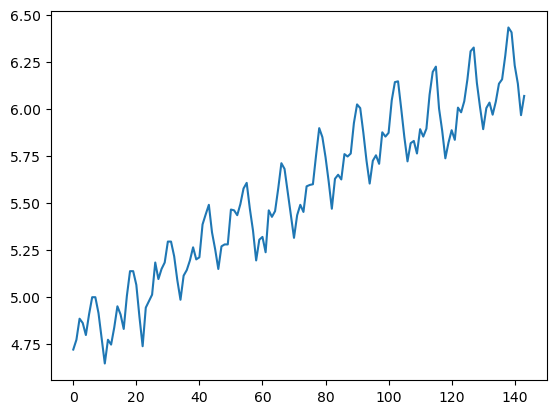

In [7]:
plt.plot(log_transformed)
plt.show()

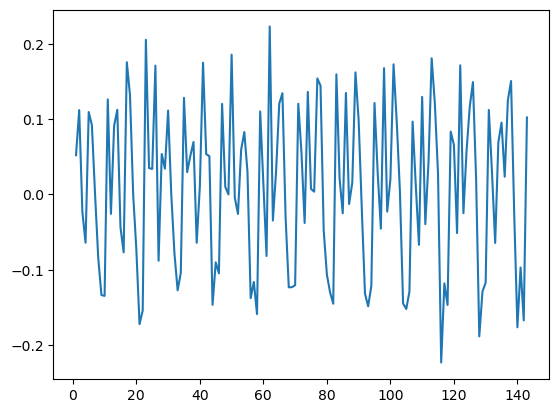

In [8]:
# 차분
diffed = log_transformed.diff()

plt.plot(diffed)
plt.show()

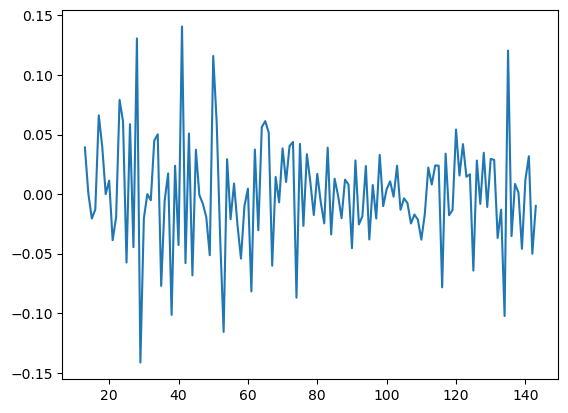

In [9]:
# 주기를 12로 하는 계절 차분
seasonally_diffed = diffed.diff(12)
# 차분 후 null 값 제거 (첫 12줄)
seasonally_diffed.dropna(inplace = True)

plt.plot(seasonally_diffed)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # ADF검정 함수
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('### ADF statistics ###', stat, sep='\n')
    print('\n### P-value ###', p_value, sep='\n')

In [11]:
adf_test(seasonally_diffed)

### ADF statistics ###
-4.443324941831131

### P-value ###
0.00024859123113839645


# 시계열 분류

In [61]:
# 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [62]:
timeseries

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [63]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [64]:
y.sum()

np.int64(21)

In [65]:
len(y) - y.sum()

np.int64(67)

In [66]:
# 데이터셋 가공
def custom_classification_split(x, y, test_size=0.3): # 수업 때 보았던 custom split 함수
    
    num_true = int(y.sum()*test_size) # 21 * 0.3 (test_size)
    num_false = int((len(y)-y.sum())*test_size) ## (88 - 21)*0.3 (test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list() # y==False 샘플중 첫 num_false 만큼 , y==True 샘플중 첫 num_true 만큼
    
    y_train = y.drop(id_list) # 0.3만큼의 test 샘플들을 제외한 나머지
    y_test = y[id_list]
    X_train = x[~x['id'].isin(id_list)] # id가 id_list에 있는 경우가 아닌 샘플 0.7은 train으로
    X_test = x[x['id'].isin(id_list)] # id가 id_list에 있는 경우가 아닌 샘플 0.3은 train으로
    
    return X_train, y_train, X_test, y_test

In [102]:
# Scikit-learn tran_test_split() 활용 데이터셋 가공
def sensor_level_split(X, y, test_size=0.3, random_state=42):
    from sklearn.model_selection import train_test_split
    
    """
    X: 전체 데이터 (센서별 시간대 row)
    y: 센서별 label (index = sensor id)
    test_size: test 비율
    """
    # 센서 아이디 추출 (1~88)
    sensor_ids = y.index.to_list() 
    
    # 센서 아이디를 랜덤으로 7:3으로 나누기()
    y_train_ids, y_test_ids = train_test_split(
            sensor_ids,
            test_size=test_size,
            stratify=y,  # True, False 각각 (1 - test_size):(test_size)로 분할
            random_state=random_state
    )

    # 위 분할된 y의 'id' 기준으로 X row 선택
    X_train = X[X['id'].isin(y_train_ids)]
    X_test  = X[X['id'].isin(y_test_ids)]
    y_train = y.loc[y_train_ids]
    y_test  = y.loc[y_test_ids]

    return X_train, X_test, y_train, y_test

In [68]:
# X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [112]:
X_train, X_test, y_train, y_test = sensor_level_split(timeseries, y, test_size=0.25, random_state=42)

In [113]:
X_train.shape[0]/15

66.0

In [128]:
y_train.shape[0]

66

In [115]:
X_test.shape[0]/15

22.0

In [129]:
y_test.shape[0]

22

In [135]:
(y == True).sum()

np.int64(21)

In [136]:
(y == False).sum()

np.int64(67)

In [124]:
(y_train == False).sum()/len(y_train)

np.float64(0.7575757575757576)

In [125]:
(y_train == True).sum()/len(y_train)

np.float64(0.24242424242424243)

In [126]:
(y_test == True).sum()/len(y_test)

np.float64(0.22727272727272727)

In [127]:
(y_test == False).sum()/len(y_test)

np.float64(0.7727272727272727)

In [87]:
X_train['id'].unique()

array([ 1,  3,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 19, 20, 22, 23,
       24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 38, 41, 43, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 75, 76, 77, 81, 83, 84, 85, 86, 87, 88])

In [90]:
X_train[X_train['id'] == 1]

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
495,34,0,71,51,5,686,494,-137
496,34,1,21,37,115,-85,55,-4
497,34,2,63,-9,6,-34,159,-10
498,34,3,13,-17,73,23,14,-2
499,34,4,0,-11,52,12,-13,0
500,34,5,8,-10,64,10,9,1
501,34,6,6,-4,57,-2,5,0
502,34,7,-3,-2,72,-7,-5,1
503,34,8,-8,1,53,-9,-15,-1
504,34,9,-1,6,74,-16,-4,-1


In [70]:
print(len(X_train)/15, len(X_test)/15)

66.0 22.0


In [71]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [72]:
# Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id='id',
                                    column_sort='time',
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████████████████████████| 40/40 [00:03<00:00, 11.35it/s]


In [73]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id='id',
                                    column_sort='time',
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████████████████████████| 33/33 [00:02<00:00, 15.15it/s]


In [74]:
# impute
impute(comprehensive_features_train)

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['T_y__partial_autocorrelation__lag_7'
 'T_y__partial_autocorrelation__lag_8'
 'T_y__partial_autocorrelation__lag_9' ...
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_x__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,T_y__variance_larger_than_standard_deviation,T_y__has_duplicate_max,T_y__has_duplicate_min,T_y__has_duplicate,T_y__sum_values,T_y__abs_energy,T_y__mean_abs_change,T_y__mean_change,T_y__mean_second_derivative_central,T_y__median,...,T_x__fourier_entropy__bins_5,T_x__fourier_entropy__bins_10,T_x__fourier_entropy__bins_100,T_x__permutation_entropy__dimension_3__tau_1,T_x__permutation_entropy__dimension_4__tau_1,T_x__permutation_entropy__dimension_5__tau_1,T_x__permutation_entropy__dimension_6__tau_1,T_x__permutation_entropy__dimension_7__tau_1,T_x__query_similarity_count__query_None__threshold_0.0,T_x__mean_n_absolute_max__number_of_maxima_7
1,0.0,1.0,1.0,1.0,-10.0,10.0,0.571429,0.000000,-0.038462,-1.0,...,0.735622,1.213008,2.079442,0.535961,0.836988,1.159589,1.227529,1.303092,0.0,3.000000
3,1.0,1.0,0.0,1.0,-29.0,103.0,2.285714,0.000000,-0.153846,-2.0,...,1.494175,1.906155,2.079442,1.498569,2.138333,2.145842,2.302585,2.197225,0.0,6.000000
5,1.0,0.0,1.0,1.0,-42.0,180.0,2.571429,-0.142857,0.038462,-3.0,...,1.494175,1.494175,2.079442,1.458319,2.138333,2.397895,2.302585,2.197225,0.0,9.428571
6,1.0,1.0,1.0,1.0,-49.0,225.0,3.071429,0.214286,0.230769,-4.0,...,1.213008,1.213008,2.079442,1.524707,2.253858,2.397895,2.302585,2.197225,0.0,11.714286
7,1.0,0.0,0.0,1.0,-52.0,234.0,2.214286,0.214286,0.000000,-4.0,...,1.320888,1.667462,2.079442,1.438883,2.094729,2.397895,2.302585,2.197225,0.0,8.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,0.0,0.0,1.0,1489.0,171261.0,16.857143,6.285714,-0.500000,107.0,...,0.735622,1.073543,1.386294,1.585771,2.094729,2.271869,2.302585,2.197225,0.0,403.571429
85,1.0,0.0,0.0,1.0,65.0,503.0,2.500000,0.642857,-0.192308,4.0,...,0.376770,0.735622,1.667462,1.631345,1.979205,2.271869,2.302585,2.197225,0.0,40.142857
86,1.0,0.0,0.0,1.0,1069.0,118013.0,12.785714,12.500000,1.500000,51.0,...,0.376770,0.376770,1.073543,1.010100,1.198849,1.540306,1.886697,2.043192,0.0,78.142857
87,1.0,0.0,0.0,1.0,5917.0,2430295.0,19.285714,17.428571,-1.500000,433.0,...,0.900256,1.213008,1.667462,1.479133,1.979205,2.271869,2.302585,2.197225,0.0,135.714286


In [75]:
impute(comprehensive_features_test)

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['T_y__partial_autocorrelation__lag_7'
 'T_y__partial_autocorrelation__lag_8'
 'T_y__partial_autocorrelation__lag_9' ...
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_x__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,T_y__variance_larger_than_standard_deviation,T_y__has_duplicate_max,T_y__has_duplicate_min,T_y__has_duplicate,T_y__sum_values,T_y__abs_energy,T_y__mean_abs_change,T_y__mean_change,T_y__mean_second_derivative_central,T_y__median,...,T_x__fourier_entropy__bins_5,T_x__fourier_entropy__bins_10,T_x__fourier_entropy__bins_100,T_x__permutation_entropy__dimension_3__tau_1,T_x__permutation_entropy__dimension_4__tau_1,T_x__permutation_entropy__dimension_5__tau_1,T_x__permutation_entropy__dimension_6__tau_1,T_x__permutation_entropy__dimension_7__tau_1,T_x__query_similarity_count__query_None__threshold_0.0,T_x__mean_n_absolute_max__number_of_maxima_7
2,1.0,0.0,0.0,1.0,-20.0,90.0,2.214286,-0.214286,-0.038462,-1.0,...,1.320888,1.494175,1.667462,1.778233,2.484907,2.397895,2.302585,2.197225,0.0,6.285714
4,1.0,0.0,0.0,1.0,-16.0,124.0,3.642857,-0.071429,-0.192308,-1.0,...,1.213008,1.667462,2.079442,1.631345,2.369382,2.397895,2.302585,2.197225,0.0,9.142857
10,0.0,1.0,0.0,1.0,-10.0,12.0,0.857143,0.000000,0.000000,-1.0,...,1.320888,1.732868,2.079442,1.418069,2.022809,2.098274,2.163956,2.197225,0.0,3.000000
12,1.0,0.0,0.0,1.0,-29.0,147.0,3.071429,-0.500000,-0.076923,-2.0,...,1.559581,1.732868,2.079442,1.479133,2.253858,2.397895,2.302585,2.197225,0.0,6.428571
18,1.0,0.0,1.0,1.0,-48.0,234.0,2.785714,-0.357143,0.153846,-4.0,...,1.073543,1.073543,1.732868,1.631345,1.979205,2.145842,2.163956,2.197225,0.0,13.000000
21,1.0,0.0,0.0,1.0,130.0,85678.0,43.642857,-18.500000,15.038462,-3.0,...,0.735622,0.735622,1.667462,1.737983,2.138333,2.271869,2.302585,2.197225,0.0,31.714286
29,1.0,0.0,0.0,1.0,-157.0,7325.0,9.357143,5.357143,-1.730769,-3.0,...,1.320888,1.494175,1.667462,1.524707,1.979205,2.145842,2.163956,2.197225,0.0,15.714286
33,1.0,0.0,0.0,1.0,-91.0,11259.0,18.857143,5.571429,-5.653846,-4.0,...,0.735622,0.735622,1.213008,1.458319,2.138333,2.397895,2.302585,2.197225,0.0,26.428571
37,1.0,0.0,0.0,1.0,-1547.0,272643.0,41.428571,2.142857,5.730769,-60.0,...,0.735622,1.073543,2.079442,1.524707,2.094729,2.271869,2.163956,2.197225,0.0,186.285714
39,1.0,0.0,0.0,1.0,88.0,6342.0,16.928571,-1.071429,-2.000000,0.0,...,0.562335,0.562335,1.732868,1.671595,1.979205,2.271869,2.302585,2.197225,0.0,43.142857


In [77]:
# RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

# RandomForest 모델 학습
rf_clf.fit(comprehensive_features_train, y_train)

# RandomForest 컬럼 순서 맞추기
comprehensive_features_test = comprehensive_features_test[comprehensive_features_train.columns]

# 모델 스코어
rf_clf.score(comprehensive_features_test, y_test)

0.7727272727272727

In [78]:
# XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델 학습
xgb_clf.fit(comprehensive_features_train, y_train)

# XGBoost 모델 스코어
xgb_clf.score(comprehensive_features_test, y_test)

0.6363636363636364

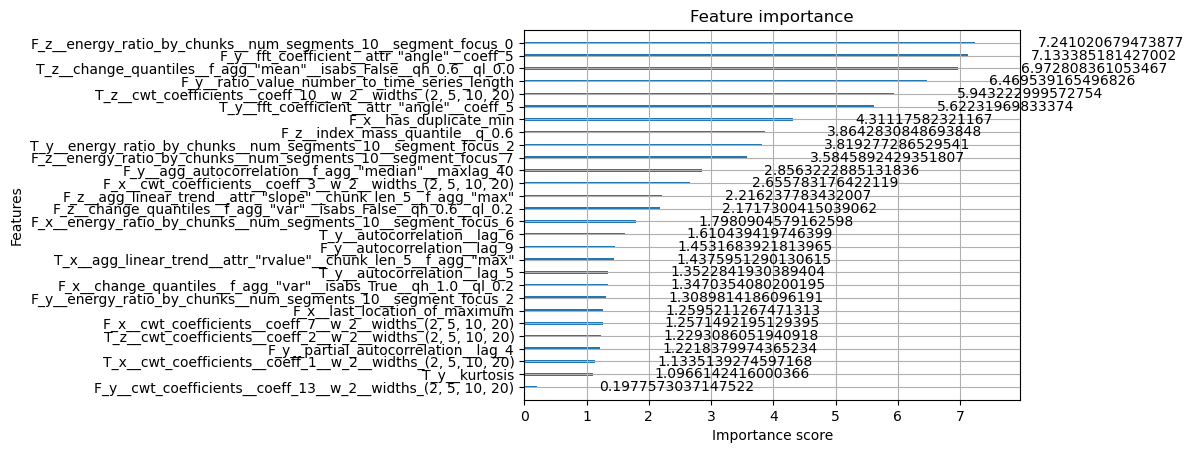

In [79]:
# XGBoost plot_importance 확인 및 시각화
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [80]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

np.int64(28)

In [81]:
# Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 0.7647058823529411,
  'recall': 0.7647058823529411,
  'f1-score': 0.7647058823529411,
  'support': 17.0},
 'false': {'precision': 0.2, 'recall': 0.2, 'f1-score': 0.2, 'support': 5.0},
 'accuracy': 0.6363636363636364,
 'macro avg': {'precision': 0.48235294117647054,
  'recall': 0.48235294117647054,
  'f1-score': 0.48235294117647054,
  'support': 22.0},
 'weighted avg': {'precision': 0.6363636363636364,
  'recall': 0.6363636363636364,
  'f1-score': 0.6363636363636364,
  'support': 22.0}}

In [82]:
classification_report(y_test, xgb_clf.predict(comprehensive_features_test), labels=[True, False], target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 0.2, 'recall': 0.2, 'f1-score': 0.2, 'support': 5.0},
 'false': {'precision': 0.7647058823529411,
  'recall': 0.7647058823529411,
  'f1-score': 0.7647058823529411,
  'support': 17.0},
 'accuracy': 0.6363636363636364,
 'macro avg': {'precision': 0.48235294117647054,
  'recall': 0.48235294117647054,
  'f1-score': 0.48235294117647054,
  'support': 22.0},
 'weighted avg': {'precision': 0.6363636363636364,
  'recall': 0.6363636363636364,
  'f1-score': 0.6363636363636364,
  'support': 22.0}}